0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:01


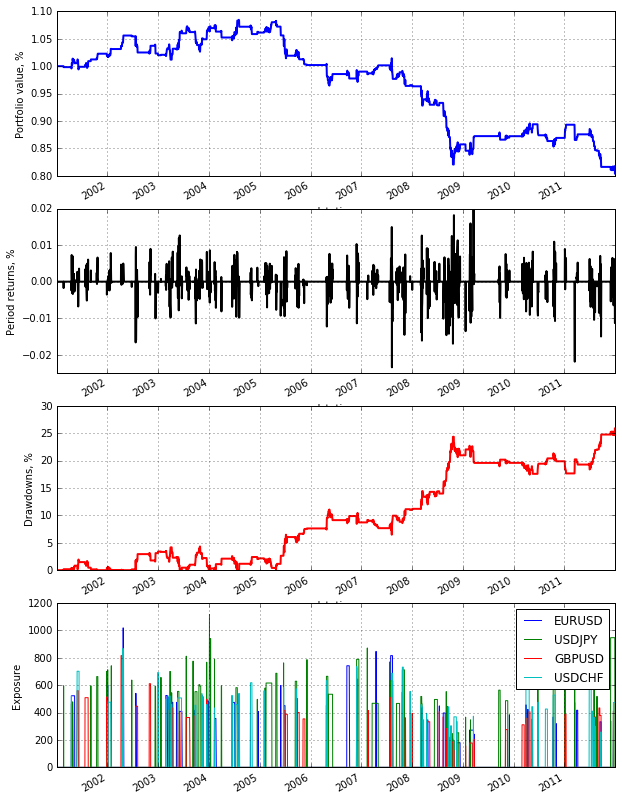

,Base Stats
#Trades,209.000000
CAGR(%),-1.964722
Avg trade(R),-0.130568
Daily Sharpe,-0.450315


In [1]:
import queue
import matplotlib.pyplot as plt
from datetime import datetime

from broker.historical_data_handler import DatabaseDataHandler,CSVDataHandler
from broker.execution_handler import SimulatedExecution
from portfolio import Portfolio
from backtest import BacktestEngine
from broker.account import SimulatedAccount
from strategy_manager import StrategyManager

from strategies.donchian_breakout import DonchianBreakout
from strategies.RSI_MOM_2 import RSI_Trading_Strategy
from strategies.PA_test import PA_Test
from strategies.ATR_GAP_TP import GapStrategy

%matplotlib inline

#PARAMETERS
symbol_list= ['EURUSD','GBPUSD','USDJPY','USDCHF']
risk= 0.01
equity = 1000.0
leverage = 20
start_date= datetime(2001,1,1)
end_date= datetime(2011,12,31)


events_queue = queue.Queue()
account = SimulatedAccount(equity,leverage,'USD')
prices = DatabaseDataHandler(events_queue=events_queue, symbol_list=symbol_list,account=account,db_adress='localhost',
                             timeframe='D1', start_date=start_date,end_date=end_date,data_vendor='FX')
#prices = CSVDataHandler(events_queue,symbol_list,account,start_date = start_date,end_date = end_date)

#strategy_4 = DonchianBreakout(prices,events_queue, entry_lookback=200, exit_lookback=100, atr_stop=3.,TP_atr=5.,name='DC_200x100')
#strategy_5 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=15, rsi_trigger_offset=25,trailing_stop_atr=1.8, take_profit_atr=3)
#strategy_6 = PA_Test(prices,events_queue,atr_stop=1.8,TP_atr=4.)
strategy_7 = GapStrategy(events_queue,prices,gap_size_atr=0.3,trailing_stop_atr=1.8,take_profit_atr=1.8)

manager = StrategyManager([strategy_7])


portfolio = Portfolio(events_queue=events_queue, prices=prices,account=account,strat_manager=manager,risk_per_trade = risk)
portfolio.open_trades.clear()
portfolio.compound=False

execution = SimulatedExecution(events_queue,prices,spread=0.0)
backtest = BacktestEngine(events_queue, prices, execution, portfolio, manager)

backtest.backtest_trading()
backtest.stats.plot_performance()
backtest.stats.output_base_stats()

# Backtest Analysis

In [5]:
backtest.stats.output_full_stats()

,All Trades,Long only,Short only
#Trades,2458,1198,1260
CAGR(%),13.9865,NaN,NaN
Avg trade(R),0.126064,0.0581284,0.190642
Daily Sharpe,0.217504,NaN,NaN
Max Drawdown(%),14.2321,NaN,NaN
Avg Duration,0 days 19:49:33.148901,0 days 20:37:21.736227,0 days 19:04:05.714285
Exposure %,31.7187,16.0947,15.624
Win Rate %,40.3987,0.388982,0.418254
Avg Win,1.66627,1.58428,1.73876
Avg Loss,-0.91791,-0.91344,-0.922398


In [7]:
trades = backtest.stats.trades
trades_per_years = trades.open_date.groupby(trades.open_date.dt.year).count()
ce = backtest.stats.cagr /trades_per_years.mean() *100
print('Cost efficiency %0.2f' %ce)
print('Avg trades_per_years',trades_per_years.mean())



Cost efficiency 0.07
Avg trades_per_years 59.09090909090909


In [7]:
from scipy import stats
import numpy as np

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

hist = backtest.stats.history
print("R-squared %0.2f" %rsquared(np.arange(len(hist.equity)),hist.equity))

R-squared 0.96


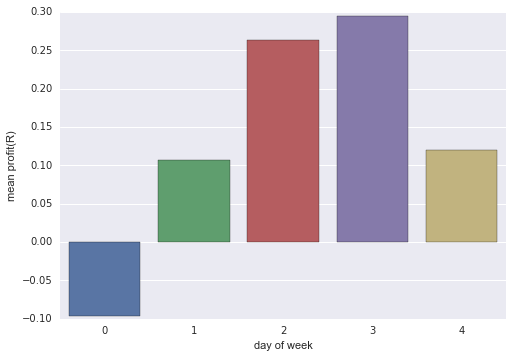

In [8]:
import seaborn as sns
import pandas as pd

df_weekday = trades[['open_date','close_date','profit_R']].reset_index()
df_weekday['open_weekday']=df_weekday.open_date.dt.dayofweek
df_weekday['close_weekday']=df_weekday.close_date.dt.dayofweek
weekday_group = df_weekday.groupby(by='open_weekday')

results = pd.DataFrame(index = weekday_group.profit_R.sum().index)
results['mean'] = weekday_group.profit_R.mean()
sns.barplot(x=results.index,y='mean',data=results)
sns.axlabel(xlabel='day of week',ylabel='mean profit(R)')

# Strategies analysis

In [9]:
strat_equities = pd.DataFrame()
trades['returns'] = trades.profit_R * risk

for strategy in strategies:
    name = strategy.identifier
    equity = (1+trades.profit_R[trades.strategy == name]).cumprod()
    strat_equities = pd.concat([strat_equities,equity],axis=1)
strat_equities.fillna(method='pad',inplace=True)

In [22]:
strat_equities

,profit_R,profit_R
ticket,,
1,NaN,5.589352e-01
2,NaN,3.101901e-01
3,NaN,9.883919e-01
4,NaN,3.426361e-01
5,NaN,8.119276e-01
6,NaN,-1.422740e-01
7,NaN,-4.388928e-01
8,NaN,-5.042347e-02
9,1.034340e+00,-5.042347e-02
